# Superficial White Matter Ribbon Extraction

Superficial white matter (SWM) is a relatively understudied form of white matter residing just below the cortex. Due to being largely overlooked, simple open source segmentations for SWM in MRI scans does not exist.

I approached this by projecting 2mm below the grey matter/white matter (GM/WM) boundary and creating a surface using FreeSurfer's `mris_expand` command. I then repurposed FreeSurfer's `mris_volmask` command (used to created a cortical ribbon mask) to detect voxels between the GM/WM boundary and 2mm below (i.e. the SWM). Look in `swm_ribbon/scripts/create_swm_ribbon.sh` for code on how to do this.

However, relating the voxels within this SWM ribbon to the overlying cortical regions is not trivial. Here I explore techniques to do this and segment the new SWM ribbon into Desikan-Killiany atlas regions of interest.

Note: A caveat is that 2mm below the GM/WM boundary is an approximation of SWM's thickness. The thickness of SWM is likely to vary between regions of the brain.  

In [29]:
# import libraries
import os
import numpy as np
import nibabel as nb
from scipy.spatial import distance, distance_matrix, cKDTree, KDTree
import matplotlib.pyplot as plt

In [30]:
# specify if you want to save extra files
save_extra = True

# specify filenames
t1_file = 'data/T1.nii.gz'
aparc_file = 'data/aparc.DKTatlas+aseg.nii.gz'
swm_file = 'data/swm-ribbon.nii.gz'
ctx_file = 'data/ribbon.nii'

# load files
t1 = nb.load(t1_file)
aparc = nb.load(aparc_file)
swm = nb.load(swm_file)
ctx = nb.load(ctx_file)

# get data arrays
t1_data = t1.get_fdata()
aparc_data = aparc.get_fdata()
swm_data = swm.get_fdata()
ctx_data = ctx.get_fdata()

I load in the images above:
1. T1 image
2. SWM ribbon created from `mris_expand` and `mris_volmask`
3. Cortical ribbon mask from standard FreeSurfer pipeline
4. Desikan-Killiany atlas parcellation

Let's check that they are the same dimensions below - this is important for indexing which will form the backbone of this work.

In [31]:
# print array dimentions of images
print(f"Shape of the T1 numpy array: {t1_data.shape}")
print(f"Shape of the SWM numpy array: {swm_data.shape}")
print(f"Shape of the Cortical numpy array: {ctx_data.shape}")
print(f"Shape of the Parcellation numpy array: {aparc_data.shape}")

Shape of the T1 numpy array: (256, 256, 256)
Shape of the SWM numpy array: (256, 256, 256)
Shape of the Cortical numpy array: (256, 256, 256)
Shape of the Parcellation numpy array: (256, 256, 256)


The cortical ribbon and SWM ribbon masks contain deeper WM. Let's remove this part of the mask to focus on the cortex and SWM ribbon only. Then I binarise the mask where cortex/SWM voxels = 1 and all other voxels = 0.

In [32]:
# only keep SWM ribbon (remove deep WM and binarise)
swm_data[(swm_data == 20) | (swm_data == 120)] = 0
swm_data[swm_data > 0] = 1

# select only cortex (remove all WM and binarise)
ctx_data[(ctx_data == 41) | (ctx_data == 2)] = 0
ctx_data[ctx_data > 0] = 1

# aparc labels= rh cortex vals 1000 - 2212; lh cortex vals 9000 - 12175

if save_extra is True:
    swmonly_fname = os.path.join(os.path.dirname(swm_file), os.path.basename(swm_file.split('.')[0])) + '_only.nii.gz'
    swmonly_nifti = nb.Nifti1Image(swm_data, swm.affine)
    nb.save(swmonly_nifti, swmonly_fname)
    print('SWM ribbon save to: ', swmonly_fname)
    
    ctxonly_fname = os.path.join(os.path.dirname(ctx_file), os.path.basename(ctx_file.split('.')[0])) + '_ctx-only.nii.gz'
    ctxonly_nifti = nb.Nifti1Image(ctx_data, ctx.affine)
    nb.save(ctxonly_nifti, ctxonly_fname)
    print('Cortical ribbon saved to: ', ctxonly_fname)

SWM ribbon save to:  data/swm-ribbon_only.nii.gz
Cortical ribbon saved to:  data/ribbon_ctx-only.nii.gz


Below I extract the coordinates in the image (256 x 256 x 256) that contain a) SWM voxels and b) cortical voxels.

In [33]:
# Extract voxel indices in the SWM and cortical regions
swm_voxels = np.argwhere(swm_data == 1)
ctx_voxels = np.argwhere(ctx_data == 1)
print(swm_voxels.shape)
print(ctx_voxels.shape)

(315341, 3)
(515997, 3)


Below shows visualisations of the data we have so far.

Left panel: T1w image overlaid with the SWM ribbon (red) and the cortical ribbon (white)

Right panel: T1w image overlaid with the SWM ribbon (red) and the Desikan-Killiany parcellation

We want to find the cortical voxels that are **closest** to those in SWM. SWM voxels can then be assigned to the region of it's closest cortical voxel.

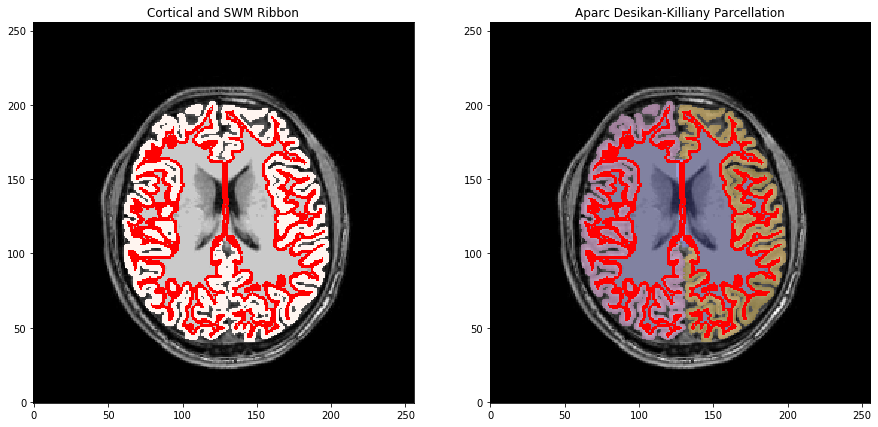

In [34]:
# mask swm and atlas for plotting (makes voxel=0 transparent)
swm_ribbon_masked = np.ma.masked_where(swm_data == 0, swm_data)
aparc_masked = np.ma.masked_where(aparc_data == 0, aparc_data)
ctx_masked = np.ma.masked_where(ctx_data == 0, ctx_data)

fig, ax = plt.subplots(nrows = 1, ncols=2, figsize = (15,15))
ax[0].imshow(t1_data[:,125,:].T, cmap="gray", origin="lower")
ax[0].imshow(ctx_masked[:,125,:].T, origin="lower", cmap="Reds")
ax[0].imshow(swm_ribbon_masked[:,125,:].T, cmap="autumn",origin="lower")
ax[0].set_title("Cortical and SWM Ribbon")

ax[1].imshow(t1_data[:,125,:].T, cmap="gray", origin="lower")
ax[1].imshow(aparc_masked[:,125,:].T, origin="lower", cmap="tab20b", alpha=0.5)
ax[1].set_title("Aparc Desikan-Killiany Parcellation")
ax[1].imshow(swm_ribbon_masked[:,125,:].T, cmap="autumn",origin="lower")


# Potential methods:


## 1. norm approach

Calculate the euclidian distance from SWM voxels to voxels in the cortical grey matter and find the closest one. See below for where I found inspiration:

https://stackoverflow.com/questions/64343663/fast-way-to-calculate-min-distance-between-two-numpy-arrays-of-3d-points


## 2. kdtree search 

This uses an algorithm to split the space into many cubes to optimise the search of the nearest neighbour.

https://stackoverflow.com/questions/53028514/calculate-distance-from-one-point-to-all-others

https://stackoverflow.com/questions/2486093/millions-of-3d-points-how-to-find-the-10-of-them-closest-to-a-given-point

https://stackoverflow.com/questions/56283314/optimize-search-of-closest-four-elements-in-two-3d-arrays

## 1. l2norm approach/distance maps

In [35]:
# calculate distance from each voxel in the SWM ribbon to each voxel in the cortex
#swm2ctx_distances = np.empty([len(swm_voxels), len(ctx_voxels)])

# this takes an absolute age and kills the kernel
#for i in range(0, len(swm2ctx_distances)):
    #swm2ctx_distances[i,:] = np.linalg.norm(swm_voxels[i]-ctx_voxels, axis=1)

In [36]:
# the equivalent way in scipy is distance_matrix
# this crashes in jupyter notebook and takes a long time - try kdtree
#dist_mat = distance_matrix(swm_voxels,ctx_voxels)

Using this approach either in jupyter notebook or pycharm runs out of memory. **Not feasible**

I have commented this out as it will crash the python kernel

## 2. kdtree
The distance map is way too slow for all the voxels I'm looking at - try the KDtree to speed it up.

A k-d tree algorithm is where you split the n dimensional space over and over again into smaller quadrants (hyper cubes) that allows you to locate points very quickly. As it is split over and over again, it has a tree-like structure with certain rules at each branch (e.g. > or < x=5?). When you have a new value, you are able to quickly traverse the tree structure (> x=5 or < x=5? > y=2 or < y=2?) to find which points are closest to your new value. In other words, you traverse the tree structure until you find yourself in the final branch which will contain nearby points.

This method is only approximate, as 2 points could be very close to each other but fall either side of one of the splits. But it is VERY fast.

https://en.wikipedia.org/wiki/K-d_tree

https://www.youtube.com/watch?v=TLxWtXEbtFE


In [37]:
# create a tree with voxels from the cortex
ctx_tree = cKDTree(ctx_voxels)

# query the tree to find the voxels in the cortex closest to the SWM voxels
distances, ndx = ctx_tree.query(swm_voxels, k=1)

# create empty nii to store nearest voxels
nearest_nii = np.zeros(ctx_data.shape)

# assign nearest voxel indices (ndx from query above) to the empty nii with value of 1
# https://zhangresearch.org/post/numpy-unravel-index/
nearest_nii[ctx_voxels[ndx][:,0], ctx_voxels[ndx][:,1], ctx_voxels[ndx][:,2]] = 1

if save_extra is True:
    # save nearest nii for figures
    nearest_fname = os.path.join(os.path.dirname(swm_file), os.path.basename(swm_file.split('.')[0])) + '_nearest_nii.nii.gz'
    nearest_nifti = nb.Nifti1Image(nearest_nii, swm.affine)
    nb.save(nearest_nifti, nearest_fname)
    print('Nearest neighbours saved to: ', nearest_fname)

Nearest neighbours saved to:  data/swm-ribbon_nearest_nii.nii.gz


After finding the nearest cortical neighbours to the SWM voxels. Plot these below.

This shows the SWM ribbon (red) and the nearest cortical voxel neighbours (white)

Text(0.5, 1.0, 'SWM Ribbon and Nearest Cortical Neighbours')

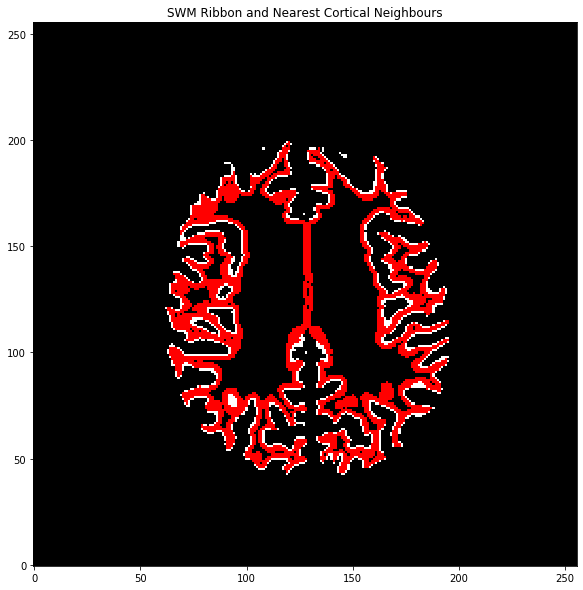

In [38]:
# plot the SWM region (red) and nearest neighbour into the cortex (white)
nii_slice = 125
fig2, ax2 = plt.subplots(figsize=(10,10))
ax2.imshow(nearest_nii[:,nii_slice,:].T, cmap="gray", origin="lower")
ax2.imshow(swm_ribbon_masked[:,nii_slice,:].T, cmap="autumn", origin="lower")
ax2.set_title("SWM Ribbon and Nearest Cortical Neighbours")

# Assign ROI values to SWM Ribbon

Finally I need to assign the parcellation values from the Desikan-Killiany atlas of in the nearest cortical neighbour voxel to corresponding SWM voxel.

First let's eyeball the coordinates of the SWM voxels and their nearest cortical neighbour.

In [39]:
# create empty aparc nii
nearest_roi = np.zeros(swm_data.shape)

# relate the nearest neighbour ROI label values back to the original SWM voxels
# swm voxel #1 -> ndx#n
# swm voxel #2 -> ndx#n
print("SWM voxels: \n", swm_voxels)
print("\n")
print("Cortical Neigbours: \n", ctx_voxels[ndx])
# value of aparc_voxel(ctx_voxels[ndx]) -> value of swm_voxel

SWM voxels: 
 [[ 60 145 108]
 [ 60 145 109]
 [ 60 145 110]
 ...
 [197 153 115]
 [197 153 116]
 [198 147 105]]


Cortical Neigbours: 
 [[ 60 144 108]
 [ 60 144 109]
 [ 60 144 110]
 ...
 [197 154 115]
 [197 154 116]
 [198 147 106]]


The above makes sense as the cortical neighbours are about one voxel away from it's corresponding SWM voxel:

SWM: [60 145 108]

Cortex: [60 144 108]

I need to find the label value of each cortical neighbour, and assign that to the corresponding SWM voxel.

This can be done using fancy indexing (yes that's actually what it's called in numpy :) ).

In [40]:
# create empty swm voxels
swm_roi = np.zeros(swm_data.shape)

# get aparc label values for the nearest voxels in the cortex
nearest_aparc = aparc_data[ctx_voxels[ndx][:,0], ctx_voxels[ndx][:,1], ctx_voxels[ndx][:,2]]

# assign these values to corresponding SWM voxels using coords in swm_voxels
swm_roi[swm_voxels[:,0], swm_voxels[:,1], swm_voxels[:,2]] = nearest_aparc

Now that each SWM voxel has an assigned regional value it's nearest cortical neighbour, we should see the SWM ribbon take on values from the overlying cortex.

Text(0.5, 1.0, 'Aparc Desikan-Killiany and SWM Parcellation')

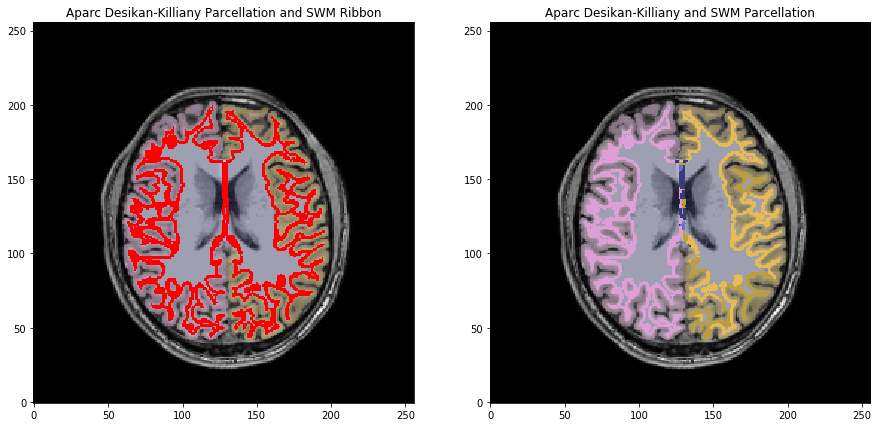

In [41]:
swm_roi_masked = np.ma.masked_where(swm_roi == 0, swm_roi)

fig3, ax3 = plt.subplots(nrows = 1, ncols=2, figsize = (15,15))

ax3[0].imshow(t1_data[:,125,:].T, cmap="gray", origin="lower")
ax3[0].imshow(aparc_masked[:,125,:].T, cmap="tab20b", origin="lower", alpha=0.3)
ax3[0].imshow(swm_ribbon_masked[:,125,:].T, cmap="autumn",origin="lower")
ax3[0].set_title("Aparc Desikan-Killiany Parcellation and SWM Ribbon")

ax3[1].imshow(t1_data[:,125,:].T, cmap="gray", origin="lower")
ax3[1].imshow(aparc_masked[:,125,:].T, cmap="tab20b", origin="lower", alpha=0.3)
ax3[1].imshow(swm_roi_masked[:,125,:].T, cmap="tab20b",origin="lower")
ax3[1].set_title("Aparc Desikan-Killiany and SWM Parcellation")


The above plots show the original SWM ribbon in red on the left with the overlying Desikan-Killiany parcellation, then the SWM ribbon that has been assigned ROI values from the overlying Desikan-Killiany parcellation. Alpha has been reduced in the overlying cortical parcellation to visualise the difference between SWM and cortex.

In [42]:
# write the final SWM regions to file
swm_roi_fname = os.path.join(os.path.dirname(swm_file), os.path.basename(swm_file.split('.')[0])) + '_rois.nii.gz'
swm_roi_nifti = nb.Nifti1Image(swm_roi, swm.affine)
nb.save(swm_roi_nifti, swm_roi_fname)
print('SWM ribbon ROIs saved to: ', swm_roi_fname)

SWM ribbon ROIs saved to:  data/swm-ribbon_rois.nii.gz


# Removing Midline

The SWM ribbon has the midline included. This is just from the `mris_expand` script but does not properly represent the underlying SWM. Explore how to remove this.

One solution could be to dilate the cortical ribbon mask (which does not have the midline included) and then only include SWM voxels that are within this dilated mask.

In [43]:
# package below does binary dilation in ndimensional space
from scipy.ndimage import binary_dilation

# dilate the GM ribbon mask
dilated_ctx = binary_dilation(ctx_data)

Let's look at the dilated mask to see if it worked

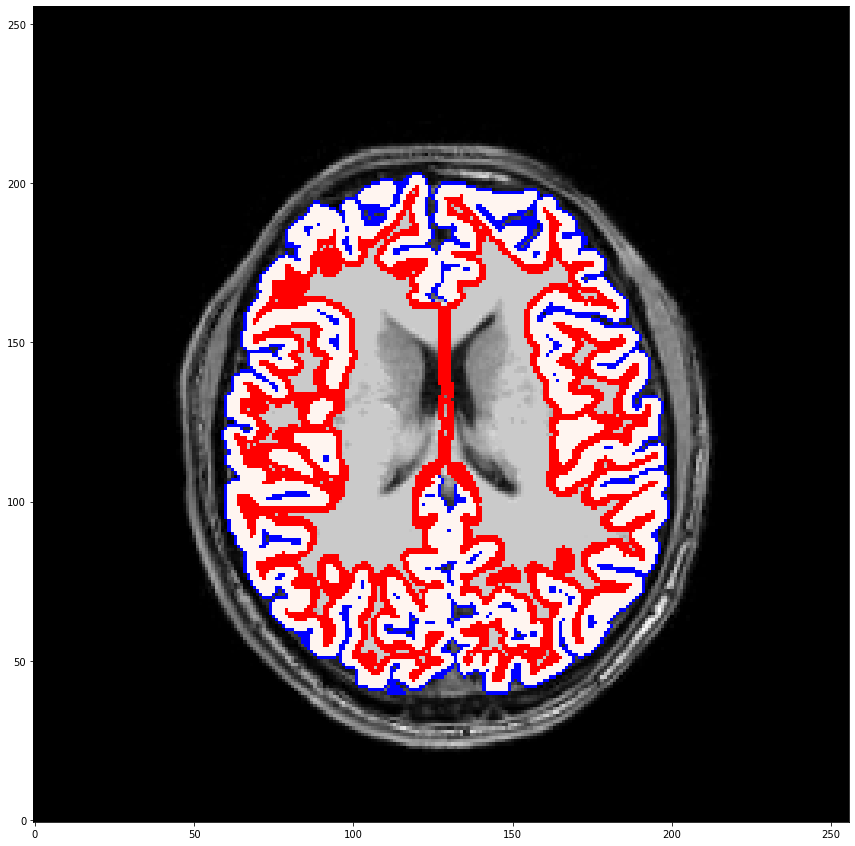

In [44]:
# first mask the 0s for overlaying
dilated_ctx_masked = np.ma.masked_where(dilated_ctx == 0, dilated_ctx)

# set up plot
fig4, ax4 = plt.subplots(figsize = (15,15))
ax4.imshow(t1_data[:,125,:].T, cmap="gray", origin="lower")
ax4.imshow(dilated_ctx_masked[:,125,:].T, cmap="winter", origin="lower")
ax4.imshow(ctx_masked[:,125,:].T, cmap="Reds", origin="lower")
ax4.imshow(swm_ribbon_masked[:,125,:].T, cmap="autumn",origin="lower")


The dilated mask (blue) doesn't seem to go far enough to include the SWM ribbon (red) under the cortex (white) but exclude the midline, let's try different dilation amounts.

In [45]:
# create list of voxels to dilate by
dil_list = [1, 2, 3, 4, 5, 6]

# set up a 4D image array to store different dilations\
dil_niis = np.zeros((ctx_data.shape[0], ctx_data.shape[1], ctx_data.shape[2], len(dil_list)))

# loop through each dilation and store in dil_niis
for idil in dil_list:
    print("Dilating ", idil, " voxels")
    # dilate
    dil_niis[:,:,:,idil-1] = binary_dilation(ctx_data, iterations=idil)

# mask zeros for plotting
masked_dil = np.zeros(dil_niis.shape)
masked_dil = np.ma.masked_where(dil_niis == 0, dil_niis)

Dilating  1  voxels
Dilating  2  voxels
Dilating  3  voxels
Dilating  4  voxels
Dilating  5  voxels
Dilating  6  voxels


Text(0.5, 1.0, '6 voxel dilation')

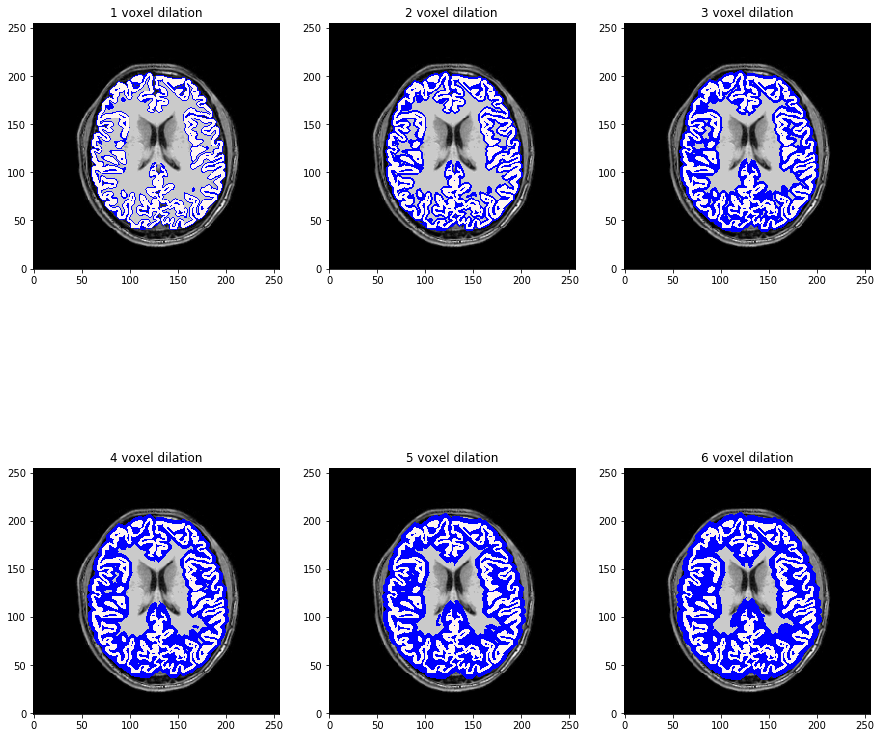

In [46]:
# setup plot
fig5, ax5 = plt.subplots(nrows = 2, ncols=3, figsize = (15,15))

ax5[0,0].imshow(t1_data[:,125,:].T, cmap="gray", origin="lower")
ax5[0,0].imshow(masked_dil[:,125,:,0].T, cmap="winter", origin="lower")
ax5[0,0].imshow(ctx_masked[:,125,:].T, cmap="Reds", origin="lower")
ax5[0,0].set_title("1 voxel dilation")

ax5[0,1].imshow(t1_data[:,125,:].T, cmap="gray", origin="lower")
ax5[0,1].imshow(masked_dil[:,125,:,1].T, cmap="winter", origin="lower")
ax5[0,1].imshow(ctx_masked[:,125,:].T, cmap="Reds", origin="lower")
ax5[0,1].set_title("2 voxel dilation")

ax5[0,2].imshow(t1_data[:,125,:].T, cmap="gray", origin="lower")
ax5[0,2].imshow(masked_dil[:,125,:,2].T, cmap="winter", origin="lower")
ax5[0,2].imshow(ctx_masked[:,125,:].T, cmap="Reds", origin="lower")
ax5[0,2].set_title("3 voxel dilation")

ax5[1,0].imshow(t1_data[:,125,:].T, cmap="gray", origin="lower")
ax5[1,0].imshow(masked_dil[:,125,:,3].T, cmap="winter", origin="lower")
ax5[1,0].imshow(ctx_masked[:,125,:].T, cmap="Reds", origin="lower")
ax5[1,0].set_title("4 voxel dilation")

ax5[1,1].imshow(t1_data[:,125,:].T, cmap="gray", origin="lower")
ax5[1,1].imshow(masked_dil[:,125,:,4].T, cmap="winter", origin="lower")
ax5[1,1].imshow(ctx_masked[:,125,:].T, cmap="Reds", origin="lower")
ax5[1,1].set_title("5 voxel dilation")

ax5[1,2].imshow(t1_data[:,125,:].T, cmap="gray", origin="lower")
ax5[1,2].imshow(masked_dil[:,125,:,5].T, cmap="winter", origin="lower")
ax5[1,2].imshow(ctx_masked[:,125,:].T, cmap="Reds", origin="lower")
ax5[1,2].set_title("6 voxel dilation")


6 Voxel dilation looks like the safest bet. Likely to include all of the SWM voxels but not go too far into the midline. Let's look in some other planes

Text(0.5, 1.0, 'Coronal')

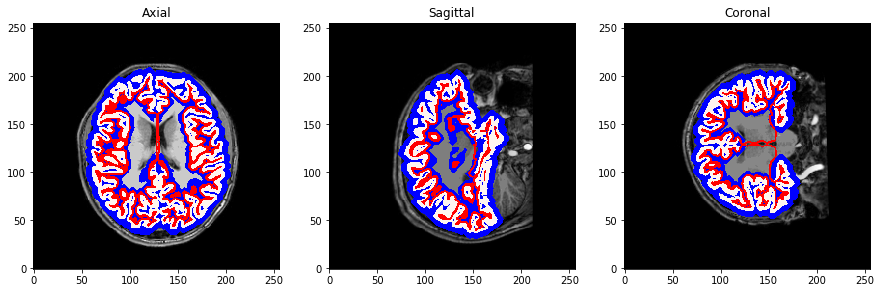

In [47]:
fig6, ax6 = plt.subplots(nrows = 1, ncols=3, figsize = (15,15))

ax6[0].imshow(t1_data[:,125,:].T, cmap="gray", origin="lower")
ax6[0].imshow(masked_dil[:,125,:,5].T, cmap="winter", origin="lower")
ax6[0].imshow(ctx_masked[:,125,:].T, cmap="Reds", origin="lower")
ax6[0].imshow(swm_ribbon_masked[:,125,:].T, cmap="autumn",origin="lower")
ax6[0].set_title("Axial")

ax6[1].imshow(t1_data[100,:,:].T, cmap="gray", origin="lower")
ax6[1].imshow(masked_dil[100,:,:,5].T, cmap="winter", origin="lower")
ax6[1].imshow(ctx_masked[100,:,:].T, cmap="Reds", origin="lower")
ax6[1].imshow(swm_ribbon_masked[100,:,:].T, cmap="autumn",origin="lower")
ax6[1].set_title("Sagittal")

ax6[2].imshow(t1_data[:,:,120], cmap="gray", origin="lower")
ax6[2].imshow(masked_dil[:,:,120,5], cmap="winter", origin="lower")
ax6[2].imshow(ctx_masked[:,:,120], cmap="Reds", origin="lower")
ax6[2].imshow(swm_ribbon_masked[:,:,120], cmap="autumn",origin="lower")
ax6[2].set_title("Coronal")


6 voxels may be too liberal and include some SWM ribbon near the brainstem.

Let's try 5 voxels

Text(0.5, 1.0, 'Coronal')

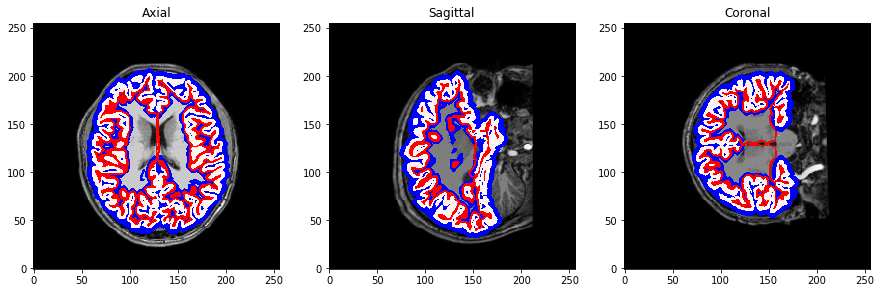

In [48]:
fig7, ax7 = plt.subplots(nrows = 1, ncols=3, figsize = (15,15))

ax7[0].imshow(t1_data[:,125,:].T, cmap="gray", origin="lower")
ax7[0].imshow(masked_dil[:,125,:,4].T, cmap="winter", origin="lower")
ax7[0].imshow(ctx_masked[:,125,:].T, cmap="Reds", origin="lower")
ax7[0].imshow(swm_ribbon_masked[:,125,:].T, cmap="autumn",origin="lower")
ax7[0].set_title("Axial")

ax7[1].imshow(t1_data[100,:,:].T, cmap="gray", origin="lower")
ax7[1].imshow(masked_dil[100,:,:,4].T, cmap="winter", origin="lower")
ax7[1].imshow(ctx_masked[100,:,:].T, cmap="Reds", origin="lower")
ax7[1].imshow(swm_ribbon_masked[100,:,:].T, cmap="autumn",origin="lower")
ax7[1].set_title("Sagittal")

ax7[2].imshow(t1_data[:,:,120], cmap="gray", origin="lower")
ax7[2].imshow(masked_dil[:,:,120,4], cmap="winter", origin="lower")
ax7[2].imshow(ctx_masked[:,:,120], cmap="Reds", origin="lower")
ax7[2].imshow(swm_ribbon_masked[:,:,120], cmap="autumn",origin="lower")
ax7[2].set_title("Coronal")

This may be a good compromise - but will need to mask the SWM ribbon's midline to check first.

Text(0.5, 1.0, 'Coronal')

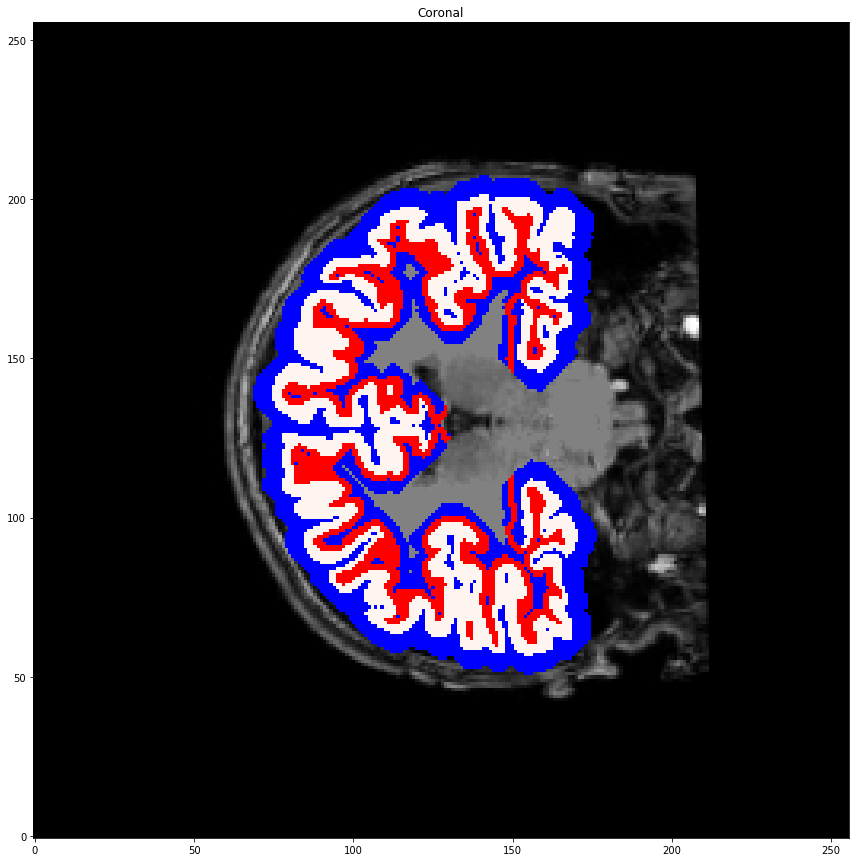

In [49]:
# keep SWM voxels that are within dilated cortical mask
cleaned_swm = np.zeros(swm_roi.shape)
cleaned_swm[(swm_data == 1) & (masked_dil[...,5] == 1)] = 1
cleaned_swm_masked = np.ma.masked_where(cleaned_swm == 0, cleaned_swm)

fig8, ax8 = plt.subplots(figsize = (15,15))

ax8.imshow(t1_data[:,:,110], cmap="gray", origin="lower")
ax8.imshow(masked_dil[:,:,110,5], cmap="winter", origin="lower")
ax8.imshow(ctx_masked[:,:,110], cmap="Reds", origin="lower")
ax8.imshow(cleaned_swm_masked[:,:,110], cmap="autumn",origin="lower")
ax8.set_title("Coronal")

This seems reasonable as it chops out the midline but won't run the risk of removing any SWM voxels in regions of interest near the cortex. This is important as varying brain morphology may affect this approach. However, some SWM ribbon remains on the thalamus side of the hippocampus.

This could be improved by using other ROI labels to exclude SWM ribbon in areas we know is not SWM.

Lets save the masked swm ribbon below.

In [50]:
# write the masked SWM region to file
swm_cleaned_fname = os.path.join(os.path.dirname(swm_file), os.path.basename(swm_file.split('.')[0])) + '_cleaned.nii.gz'
swm_cleaned_nifti = nb.Nifti1Image(cleaned_swm, swm.affine)
nb.save(swm_cleaned_nifti, swm_cleaned_fname)
print('Cleaned SWM ribbon saved to: ', swm_cleaned_fname)

Cleaned SWM ribbon saved to:  data/swm-ribbon_cleaned.nii.gz


## Just using cortical ROI labels
Could just only keep voxels that have the cortical ROI label associated with it

Cortex values are > 1000

In [51]:
# keep voxels in swm ROI ribbon that are only associated with cortical ROIs (>= 1000 are cortex)
swm_roi[swm_roi < 1000] = 0

# also remove non-cortical voxels from the binary swm ribbon mask too
cleaned_swm[swm_roi < 1000] = 0

Use a combination of dilation and keeping cortical ROI-related SWM voxels to capture different type of cleaning needed across varying morphologies.

# Final SWM Ribbon Pipeline

With all the above, the main steps for extracting SWM ribbon are:

1. Calculate SWM ribbon using FreeSurfer's `mris_expand` and `mris_volmask`
2. Dilate cortical mask and remove midline voxels in SWM ribbon
3. Find nearest cortical neighbours to SWM voxels
4. Assign label values of nearest cortical neighbours to corresponding SWM voxels
5. Keep SWM voxels that have an associated cortical label

These can be found in `scripts/extract_swm_ribbon.py`